Why exactly is it helpful for an algorithm to be able to classify high-z sources from their spectra?
Ultimately science goal to use high-z to constrain cosmological parameters. How accurately we can constrain depends on . The better we can measure Ly-a the better the cosmological parameters. Increasing data volume. Finding high-z in an automated way, for HETDEX goals. 


# Questions 03/29/23:

* What do I do with spec_err?

    - Divide the original spectrum over spec_err to try and cancel out noise.

* Do I have to standard scale the noise too? Can I just standard scale the highz?

    - For the sake of consistency, should use it on both.
    
# Notes 03/29/23:

## Things to do:
    * Get a plot of the three normal high-z, spec err, and divided (do this for false positives and false negatives)
        - create a function (define ax.plot), takes in high-z spec and spec err and then gives us three plots.
        - ax.plot can pass and return into functions.
    * Visually inspect the classifications.
    
    Get x and y for spectra plots
    
## Presentation

    - They are interesting sources
    - Lyman Alpha cna be used to retrace reionzation, periond of unknown universe time. Can use lyman alpha to retrace back in time.
    - High redshift cause that is when reionization occurs.

http://ned.ipac.caltech.edu/level5/March19/Baron/Baron2.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Using this to be able to plot spectra. For some reason Jupyter won't let me plot spectra without this
%matplotlib inline

In [3]:
# loading in the decoded sources I got from inputting random encoded sources into t-sne.
# These will be our testing sample
random_highz_sources = np.load("highz_sources.npy")

In [4]:
# loading in my high confidence high z sources.
high_confidence_highz_spectra_sn7 = np.load("high_confidence_highz_sn7_10000.npy", allow_pickle = True)
high_confidence_highz_spec_err_sn7 = np.load("high_confidence_highz_spec_err_sn7_10000.npy", allow_pickle = True)

In [182]:
# This code below takes my high-confidence high redshift sample and divides it by the high-confidence error. 
# Basically reduces the noisy parts and keeps the peaks (not perfect but really well).
# Returns the de-noised spectra into an array called 'high_confidence_over_specc_err'

num_sources = high_confidence_highz_spectra_sn7.shape[0]
confidence_over_spec_err_LS = [[0] * 1 for i in range(num_sources)]

counter = 0

while counter < num_sources:
    confidence_over_spec_err_LS[counter] = \
    high_confidence_highz_spectra_sn7[counter] / high_confidence_highz_spec_err_sn7[counter]
    
    counter += 1

high_confidence_over_specc_err = np.array(confidence_over_spec_err_LS)

In [8]:
# loading in the noise sample.
noise_sample = np.load("noise_sample_10000.npy", allow_pickle = True)

## Random-Forest classification

https://levelup.gitconnected.com/random-forest-regression-209c0f354c84#:~:text=Random%20Forest%20Regression%20is%20a%20supervised%20learning%20algorithm%20that%20uses,prediction%20than%20a%20single%20model.

https://www.datacamp.com/tutorial/random-forests-classifier-python

## According to internet, issues with overfitting! Possibly need more data.

https://stackoverflow.com/questions/62445343/randomforestregressor-in-sklearn-giving-negative-scores

In [9]:
#twodspectra = np.concatenate((sliced_highz, sliced_noise))
#twodspectra = np.concatenate((high_confidence_highz_spectra_sn7, noise_sample))
twodspectra = np.concatenate((high_confidence_over_specc_err, noise_sample))
#twodspectra = np.concatenate((normalized_highz, normalized_noise))
#twodspectra = np.concatenate((stdscaler_highz, stdscaler_noise))

In [10]:
highz_classification = np.ones(10000)
noise_classification = np.zeros(10000)

merge_classification = np.append(highz_classification, noise_classification)

### Make my own labels:
https://towardsdatascience.com/labeling-data-with-pandas-9e573ce59c42

In [11]:
X = twodspectra
y = merge_classification

In [12]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

Before applying any scaling transformations it is very important to split your data into a train set and a test set. If you start scaling before, your training (and test) data might end up scaled around a mean value (see below) that is not actually the mean of the train or test data, and go past the whole reason why you’re scaling in the first place.

In [13]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

### Note on number of estimators/trees
- The more trees you have the more accurate the model will be, however it only helps a certain amount. I started with 100 estimators (and no changing of any parameters) and got an accuracy of around ~67-69%, I then increased to 500 estimators and got ~70-71% and then I went to 1000 estimators and it stayed the same as with 500 estimators. I even went to 10,000 and it stayed the same (might have even gone lower) as with 1000 estimators. Also takes awhile to run with 10,000. If anything 500 might have better accuracy.

In [14]:
# creating a RF classifier
rfc = RandomForestClassifier(n_estimators = 700, random_state = 42)  

In [15]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=700, random_state=42)

In [16]:
# performing predictions on the test dataset
y_pred = rfc.predict(X_test)

In [17]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9855
Precision: 0.9819078947368421
Recall: 0.9893934371892609


In [18]:
# View confusion matrix for test data and predictions
#metrics.confusion_matrix(y_test, y_pred)

In [19]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred, normalize = 'true').ravel()

In [20]:
(tn, fp, fn, tp)

(0.9815621857190747,
 0.01843781428092524,
 0.010606562810739144,
 0.9893934371892609)

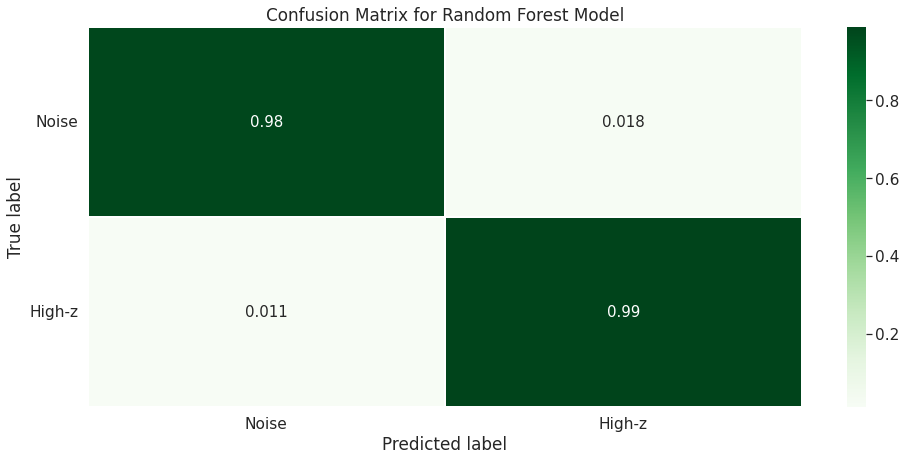

In [21]:
# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Noise', 'High-z']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names, rotation= 0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [143]:
false_positive = X_test[(y_test == 0) & (y_pred == 1)]  # predicted high-z but actually noise
false_negative = X_test[(y_test == 1) & (y_pred == 0)]  # predicted noise but actually high-z

true_positive = X_test[(y_test == 1) & (y_pred == 1)] # predicted high-z and actually high-z
true_negative = X_test[(y_test == 0) & (y_pred == 0)] # predicted noise and actually noise

high_confidence_over_specc_err = high_confidence_highz_spectra_sn7 / high_confidence_highz_spec_err_sn7

so basically, we can use algebra to find any of these, since we have all the values

high_confidence_highz_spectra_sn7 = high_confidence_over_specc_err * high_confidence_highz_spec_err_sn7

In [187]:
false_negative[0]

array([ 0.5890363 ,  0.58882967,  0.58862265, ..., -0.23685773,
       -0.23685748, -0.23685722])

In [194]:
np.where(high_confidence_over_specc_err == false_negative[0])[0][0]

695

In [181]:
high_confidence_over_specc_err[695]

array([ 0.5890363 ,  0.58882967,  0.58862265, ..., -0.23685773,
       -0.23685748, -0.23685722])

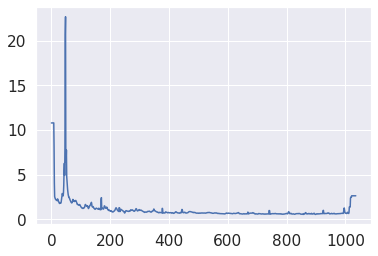

In [190]:
plt.plot(high_confidence_highz_spec_err_sn7[695])

In [30]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [233]:
# high_confidence_over_specc_err = high_confidence_highz_spectra_sn7 / high_confidence_highz_spec_err_sn7
def false_neg_check(n):
    #x = np.linspace(0, 100)
    # getting the index of where this false_neg is in the original array
    idx = np.where(high_confidence_over_specc_err == false_negative[n])[0][0]
    y = false_negative[n]
    y2 = high_confidence_highz_spectra_sn7[idx]
    y3 = high_confidence_highz_spec_err_sn7[idx]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(16, 4));
    ax1.plot(y)
    ax1.title.set_text("high-z/spec_err")
    ax2.plot(y2)
    ax2.title.set_text("high-z")
    ax3.plot(y3)
    ax3.title.set_text("spec_err")
    plt.show()
    
widgets.interact(false_neg_check, n=(0, false_negative.shape[0] - 1));

interactive(children=(IntSlider(value=15, description='n', max=31), Output()), _dom_classes=('widget-interact'…

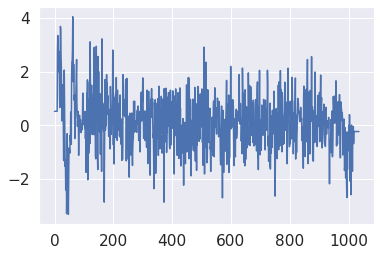

In [219]:
plt.plot(false_negative[12])

In [220]:
ind = np.where(high_confidence_over_specc_err == false_negative[12])[0][0]

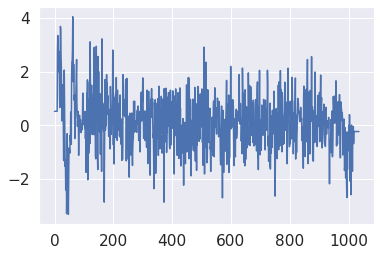

In [221]:
plt.plot(high_confidence_over_specc_err[ind])

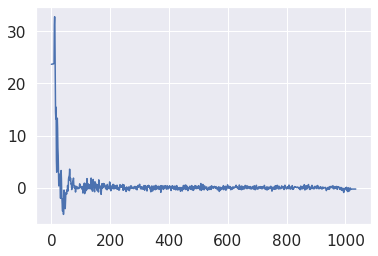

In [222]:
plt.plot(high_confidence_highz_spectra_sn7[ind])

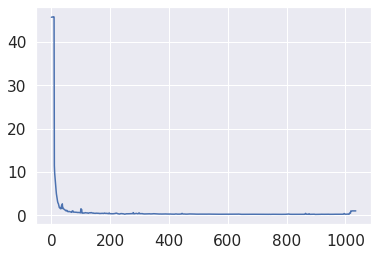

In [223]:
plt.plot(high_confidence_highz_spec_err_sn7[ind])

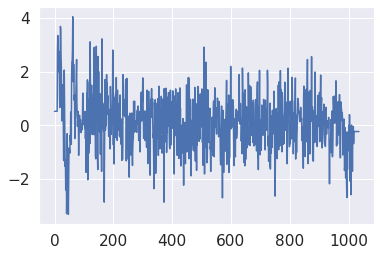

In [224]:
plt.plot(high_confidence_highz_spectra_sn7[ind]/high_confidence_highz_spec_err_sn7[ind])

In [213]:
def false_pos_check(n):
    #x = np.linspace(0, 100)
    y = false_positive[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    ax.plot(y)
    plt.show()
    
widgets.interact(false_pos_check, n=(0, false_positive.shape[0] - 1));

interactive(children=(IntSlider(value=27, description='n', max=54), Output()), _dom_classes=('widget-interact'…

In [162]:
def true_pos_check(n):
    #x = np.linspace(0, 100)
    y = true_positive[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    ax.plot(y)
    plt.show()
    
widgets.interact(true_pos_check, n=(0, true_positive.shape[0] - 1));

interactive(children=(IntSlider(value=1492, description='n', max=2984), Output()), _dom_classes=('widget-inter…

### Data set with sn > 7 and check if there's a difference to give us less false positives
### Warm start
### sklearn standard scaler (OR ANOTHER OPTION)
### cross correlation
### RandomParameterSearch
### Pass in the signal to noise spectrum (spec_err)

In [ ]:
a = np.arange(10)
print(a[a <= 2]) # Will only capture elements <= 2 and ignore others

In [ ]:
# metrics are used to find accuracy or error 
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = { 
    'n_estimators': [500, 700, 1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [None, 100, 1000],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring = 'accuracy', cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
# creating a RF classifier
rfc2 = RandomForestClassifier(n_estimators = 700, criterion = 'gini', \
                              max_features = 'sqrt', random_state = 42)  

In [ ]:
rfc2.fit(X_train, y_train)

In [ ]:
y_pred = rfc2.predict(X_test)

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

In [ ]:
clf.predict(X_test[0].reshape(1, -1))

In [ ]:
clf.predict(X_test[1].reshape(1, -1))

In [ ]:
y_test[0]

In [ ]:
y_test[1]

In [ ]:
plt.plot(X_test[0])

In [ ]:
plt.plot(X_test[1])

Idk how much this would help but i recall that certain algorithms do better when the data is normalized. Maybe we can try implementing that and see how it does.
I think sklearn has some standard scaler that normalizes the data in a way to be used for ML purposes
white_check_mark
eyes
raised_hands





11:14
We can also look into the documentations and see what parameters we think has a big impact on the classification
11:15
and tweak those one at a time to see which has the biggest impact

In [ ]:
from sklearn import tree
import dtreeviz # will be used for tree visualization

In [ ]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(clf.estimators_[0], feature_names=X, filled=True)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf.fit(X, y)

In [ ]:
plt.figure(figsize=(18,18))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X, filled=True, fontsize = 10)

In [ ]:
viz = dtreeviz.model(rf.estimators_[0], X, y, feature_names=X, target_name="Target")

In [ ]:
viz.view() 

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0],
          class_names=["highz", "noise"], 
          filled=True, impurity=True, 
          rounded=True)

In [ ]:
plt.plot(X[42])

In [ ]:
plt.plot(X[984])

## Plotting
https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f 

https://builtin.com/data-science/random-forest-python-deep-dive

https://vitalflux.com/random-forest-classifier-python-code-example/

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

#GRIDSEARCHCV
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Different models

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

# Article for data prep
https://www.analyticsvidhya.com/blog/2021/06/4-ways-to-handle-insufficient-data-in-machine-learning/

### 03/01/23

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
https://www.keboola.com/blog/random-forest-regression#:~:text=If%20you%20want%20to%20increase,the%20maximum%20number%20of%20features.
https://www.kaggle.com/questions-and-answers/261231
https://www.kdnuggets.com/2018/12/feature-engineering-explained.html#:~:text=Feature%20Engineering%20Example%3A%20Continuous%20data,some%20object%20on%20the%20map.
https://www.analyticsvidhya.com/blog/2021/06/4-ways-to-handle-insufficient-data-in-machine-learning/
https://opg.optica.org/ol/fulltext.cfm?uri=ol-44-23-5864&id=423702
https://opg.optica.org/view_article.cfm?pdfKey=eb0ab124-2dbd-48bc-a1ae9c5771f8fea1_423702
https://www.nature.com/articles/s41467-021-21481-0
https://www.aanda.org/articles/aa/full_html/2016/07/aa28660-16/aa28660-16.html
https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501